# Lezione 6

In [ ]:
from itertools import count

from liblet import cyk2table, Production, Grammar, Tree

# L'algoritmo CYK

## La tabella `R` e la sua relazione con l'input

In [ ]:
INPUT = 'unaprova'

R = {}
for l in range(1, len(INPUT) + 1):
    for i in range(1, len(INPUT) - l + 2): 
        R[(i, l)] = INPUT[i - 1 : i + l - 1]

R

{(1, 1): 'u',
 (2, 1): 'n',
 (3, 1): 'a',
 (4, 1): 'p',
 (5, 1): 'r',
 (6, 1): 'o',
 (7, 1): 'v',
 (8, 1): 'a',
 (1, 2): 'un',
 (2, 2): 'na',
 (3, 2): 'ap',
 (4, 2): 'pr',
 (5, 2): 'ro',
 (6, 2): 'ov',
 (7, 2): 'va',
 (1, 3): 'una',
 (2, 3): 'nap',
 (3, 3): 'apr',
 (4, 3): 'pro',
 (5, 3): 'rov',
 (6, 3): 'ova',
 (1, 4): 'unap',
 (2, 4): 'napr',
 (3, 4): 'apro',
 (4, 4): 'prov',
 (5, 4): 'rova',
 (1, 5): 'unapr',
 (2, 5): 'napro',
 (3, 5): 'aprov',
 (4, 5): 'prova',
 (1, 6): 'unapro',
 (2, 6): 'naprov',
 (3, 6): 'aprova',
 (1, 7): 'unaprov',
 (2, 7): 'naprova',
 (1, 8): 'unaprova'}

In [ ]:
cyk2table(R)

## Due modi per riempire la tabella…

Supponendo di avere la funzione `fill(R, i, l)` che restituisce il valore di `R[(i, l)`.

In [ ]:
def offline(fill, n):
    R = {}
    for l in range(1, n + 1):
        for i in range(1, n - l + 2): 
            R[(i, l)] = fill(R, i, l)
    return R

In [ ]:
def online(fill, n):
    R = {}
    for d in range(1, n + 1):
        for i in range(d, 0, -1):
            R[(i, d - i + 1)] = fill(R, i, d - i + 1)
    return R

La seguente funzione `fill`, ignorando i parametri, restituisce un numero progressivo (usando `count` del modulo `itertools`).

In [ ]:
def fill_counter(R, i, l):
    return next(cnt)

Usando `offline` e `online` con il contatore si visualizza l'ordine di riempimento

In [ ]:
cnt = count(1)
R = offline(fill_counter, 5)
cyk2table(R)

In [ ]:
cnt = count(1) 
R = online(fill_counter, 5)
cyk2table(R)

## Filtrare le produzioni coi predicati

Usando la funzione *builtin* `filter` e un *predicato*  si può ottenere un sottoiteratore.

In [ ]:
def pari(x):
    return x % 2 == 0

list(filter(pari, range(10)))

[0, 2, 4, 6, 8]

Vediamo due predicati per le produzioni…

In [ ]:
prods = Production.from_string("""
A -> a
A -> B C
""")
prods

(A -> a, A -> B C)

In [ ]:
# quelle con rhs lungo 2

list(filter(Production.such_that(rhs_len = 2), prods))

[A -> B C]

In [ ]:
# e quelle con rhs lungo 1

list(filter(Production.such_that(rhs_len = 1), prods))

[A -> a]

## Il riempimento dell'algoritmo CYK

In [ ]:
def cyk_fill(G, INPUT):
    def fill(R, i, l):
        res = set()
        if l == 1:
            for A, (a,) in filter(Production.such_that(rhs_len = 1), G.P): 
                if a == INPUT[i - 1]: res.add(A)
        else:
            for k in range(1, l):
                for A, (B, C) in filter(Production.such_that(rhs_len = 2), G.P):
                    if B in R[(i, k)] and C in R[(i + k, l - k)]: res.add(A)
        return res
    return fill

Qualche esempio su una grammatica per `a`$^n$`.`

In [ ]:
G = Grammar.from_string("""
S -> A S
A -> a
S -> .
""")

In [ ]:
INPUT = 'aaa.'

R = online(cyk_fill(G, INPUT), len(INPUT))
cyk2table(R)

In [ ]:
INPUT = 'aa.a.'

R = online(cyk_fill(G, INPUT), len(INPUT))
cyk2table(R)

Una grammatica più complessa (per i numeri decimali con virgola, in notazione scientifica)

In [ ]:
# fig. 4.15, pag. 123 

G = Grammar.from_string("""
Number -> 0|1|2|3|4|5|6|7|8|9 
Number -> Integer Digit
Number -> N1 Scale' | Integer Fraction
N1 -> Integer Fraction
Integer -> 0|1|2|3|4|5|6|7|8|9 
Integer -> Integer Digit
Fraction -> T1 Integer
T1 -> .
Scale' -> N2 Integer
N2 -> T2 Sign
T2 -> e
Digit -> 0|1|2|3|4|5|6|7|8|9 
Sign -> + | -
""")

In [ ]:
INPUT = '32.5e+1'

R = offline(cyk_fill(G, INPUT), len(INPUT))
cyk2table(R)

## Generare l'albero di parsing (barando)

La tabella contiene non terminali e, in accordo al criterio usato per riempirla, tali non terminali possono essere raccolti in un albero che ha l'aspetto di un albero di derivazione — anche se costruito senza riferimento alle produzioni (dal quale non è quindi banale ricostruire la derivazione).

Scriviamo una funzione ricorsiva `parse_lol` che (usando tabella `R`, la grammatica `G` e l'input `INPUT`) dato un non terminale, il punto d'inizio e la lunghezza, restituisca un *lol* che rappresenta l'albero di parsing radicato in quel non terminale e che deriva la sottostringa specificata.

In [ ]:
def parse_lol(X, i, l):
    if l == 1: return [X, [INPUT[i-1]]]
    for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
        for k in range(1, l):
            if B in R[(i, k)] and C in R[(i + k, l - k)]:
                return [A, parse_lol(B, i, k), parse_lol(C, i + k, l - k)]

In [ ]:
lol = parse_lol('Number', 1, len(INPUT))
lol

['Number',
 ['N1',
  ['Integer', ['Integer', ['3']], ['Digit', ['2']]],
  ['Fraction', ['T1', ['.']], ['Integer', ['5']]]],
 ["Scale'", ['N2', ['T2', ['e']], ['Sign', ['+']]], ['Integer', ['1']]]]

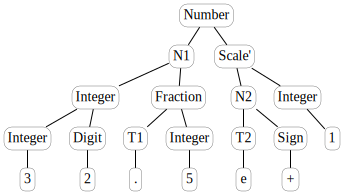

In [ ]:
Tree.from_lol(lol)